In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW

import nibabel as nib
from nilearn import maskers
from nilearn.plotting import plot_stat_map

from neurovlm.models import NeuroAutoEncoder
from neurovlm.data import load_dataset, data_dir
from neurovlm.train import Trainer, which_device
from neurovlm.models import ProjHead
from neurovlm.loss import InfoNCELoss

device = which_device()

## Autoencoder

In [2]:
# Load vectors from 01_coordinate.ipynb
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False,
).values()

# Filter for studies with less than 100 coordinates
df_coords = pd.read_parquet(data_dir / "coordinates.parquet")
counts = df_coords[df_coords['pmid'].isin(pmids)]["pmid"].value_counts()
mask = pd.Series(pmids).isin(counts.index[counts <= 100].values)
pmids = np.array(pmids[mask])
neuro_vectors = neuro_vectors[mask]

kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
for idx, (train, test) in enumerate(kf.split(np.arange(len(pmids)))):

    train = torch.from_numpy(train)
    test = torch.from_numpy(test)

    # split val out of train
    train_inds = torch.randperm(len(train))
    val_size = int((len(train) + len(test)) * 0.05)
    val = train[train_inds[:val_size]]
    train = train[train_inds[val_size:]]

    trainer = Trainer(
        NeuroAutoEncoder(seed=idx, out="logit"),
        n_epochs=101,
        batch_size=256,
        lr=5e-5,
        loss_fn=nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        X_val=neuro_vectors[val],
        device="auto",
        interval=10
    )

    # Fit
    trainer.fit(neuro_vectors[train])

    # Save
    trainer.save(data_dir / f"autoencoder_kfold-{str(idx)}.pt")

    print("saved fold " + str(idx))

Epoch: -1, val loss: 0.69322
Epoch: 0, val loss: 0.17445
Epoch: 10, val loss: 0.085977
Epoch: 20, val loss: 0.080296
Epoch: 30, val loss: 0.075113
Epoch: 40, val loss: 0.072793
Epoch: 50, val loss: 0.071059
Epoch: 60, val loss: 0.069207
Epoch: 70, val loss: 0.067323
Epoch: 80, val loss: 0.065864
Epoch: 90, val loss: 0.064583
Epoch: 100, val loss: 0.063525
saved fold 0
Epoch: -1, val loss: 0.69322
Epoch: 0, val loss: 0.18235
Epoch: 10, val loss: 0.089609
Epoch: 20, val loss: 0.083906
Epoch: 30, val loss: 0.078718
Epoch: 40, val loss: 0.077066
Epoch: 50, val loss: 0.075064
Epoch: 60, val loss: 0.073434
Epoch: 70, val loss: 0.071368
Epoch: 80, val loss: 0.069642
Epoch: 90, val loss: 0.068331
Epoch: 100, val loss: 0.06728
saved fold 1
Epoch: -1, val loss: 0.69313
Epoch: 0, val loss: 0.1796
Epoch: 10, val loss: 0.085403
Epoch: 20, val loss: 0.080272
Epoch: 30, val loss: 0.074733
Epoch: 40, val loss: 0.072473
Epoch: 50, val loss: 0.070468
Epoch: 60, val loss: 0.068524
Epoch: 70, val loss: 0.

## Projection Heads

In [3]:
# specter2 was trained independently of the the neurovlm datasets
latent_text_specter, pmids_specter = torch.load(
    data_dir / f"latent_specter2_adhoc.pt", weights_only=False, map_location="cpu"
).values()
mask = pd.Series(pmids_specter).isin(pmids)
latent_text_specter = latent_text_specter[mask]
pmids_specter = pmids_specter[mask]
assert (pmids_specter == pmids).all()

In [ ]:
for idx, (train, test) in tqdm(enumerate(kf.split(np.arange(len(pmids)))), total=5):

    autoencoder = torch.load(data_dir / f"autoencoder_kfold-{str(idx)}.pt", weights_only=False).eval()
    latent_neuro = autoencoder.encoder(neuro_vectors.to(device)).detach()

    # splits
    train = torch.from_numpy(train)
    test = torch.from_numpy(test)

    train_inds = torch.randperm(len(train))
    val_size = int((len(train) + len(test)) * 0.05)
    val = train[train_inds[:val_size]]
    train = train[train_inds[val_size:]]

    X_train  = latent_text_specter[train]
    X_test  = latent_text_specter[test]
    X_val  = latent_text_specter[val]

    # y_train = neuro_vectors[train]
    # y_test = neuro_vectors[test]
    # y_val = neuro_vectors[val]
    y_train = latent_neuro[train]
    y_test = latent_neuro[test]
    y_val = latent_neuro[val]

    # text-to-brain
    proj_head = ProjHead(seed=idx, latent_in_dim=768, hidden_dim=512, latent_out_dim=384)

    trainer = Trainer(
        proj_head,
        batch_size=1024,
        n_epochs=501,
        lr=1e-4,
        loss_fn=nn.MSELoss(),
        optimizer=torch.optim.AdamW,
        X_val=X_val,
        y_val=y_val,
        device="auto",
        verbose=False
    )

    trainer.fit(X_train.to(device), y_train.to(device))
    proj_head = trainer.model
    torch.save(proj_head, data_dir / f"proj_head_text_mse_kfold-{str(idx)}.pt")

    # contrastive
    latent_neuro = autoencoder.encoder(neuro_vectors.to(device)).detach()

    X_train_image = latent_neuro[train].to(device)
    X_train_text  = latent_text_specter[train].to(device)

    X_val_image = latent_neuro[val].to(device)
    X_val_text  = latent_text_specter[val].to(device)

    X_train_text  = F.normalize(X_train_text,  dim=1, eps=1e-8)
    X_val_text    = F.normalize(X_val_text,    dim=1, eps=1e-8)

    proj_head_text  = proj_head.to(device) # initialize with the decoder model

    proj_head_image = ProjHead(
        seed=123, latent_in_dim=384, hidden_dim=384, latent_out_dim=384
    ).to(device)

    loss_fn = InfoNCELoss(temperature=0.07)
    n_epochs = 301
    batch_size = 2048
    lr = 2e-5
    optimizer = AdamW([*proj_head_text.parameters(), *proj_head_image.parameters()], lr=lr)
    interval = 20

    iterable = tqdm(range(n_epochs), total=n_epochs)

    for iepoch in iterable:

        proj_head_text.train()
        proj_head_image.train()

        # Randomly shuffle and batch
        torch.manual_seed(iepoch)
        rand_inds = torch.randperm(len(X_train_image), device=device)

        for i in range(0, len(X_train_image), batch_size):
            inds = rand_inds[i:i+batch_size]

            # Forward
            y_text  = proj_head_text(X_train_text[inds])
            y_image = proj_head_image(X_train_image[inds])

            # Loss
            loss = loss_fn(y_text, y_image)

            # Backward
            optimizer.zero_grad(set_to_none=True)
            loss.backward()

            # Step
            optimizer.step()

        # Report validation
        if iepoch % interval == 0 or iepoch == (n_epochs - 1):
            proj_head_text.eval()
            proj_head_image.eval()
            with torch.no_grad():
                y_text  = proj_head_text(X_val_text)
                y_image = proj_head_image(X_val_image)
                val_loss = loss_fn(y_text, y_image)

    torch.save(proj_head_text, data_dir / f"proj_head_text_infonce_kfold-{str(idx)}.pt")
    torch.save(proj_head_image, data_dir / f"proj_head_image_infonce_kfold-{str(idx)}.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

## Evaluation

In [ ]:
from neurovlm.metrics import compute_ae_performance, recall_curve, auc
import matplotlib.pyplot as plt
from neurovlm.models import load_model

specter = load_model("specter").to(device)
features = np.load(data_dir / "ngram_labels.npy")
with torch.no_grad():
    feature_emb = F.normalize(proj_head_text.to("cpu")(F.normalize(specter(features.tolist()).to("cpu"), dim=1)), dim=1)

In [195]:
txt_to_img = []
img_to_txt = []
true_to_gen_t2b = []
gen_to_true_t2b = []
true_to_gen_b2t = []
gen_to_true_b2t = []

for idx, (train, test) in tqdm(enumerate(kf.split(np.arange(len(pmids)))), total=5):

    # Load pre-trained (from above)
    autoencoder = torch.load(data_dir / f"autoencoder_kfold-{str(idx)}.pt", weights_only=False).eval()
    proj_head_text = torch.load(data_dir / f"proj_head_text_infonce_kfold-{str(idx)}.pt", weights_only=False).eval()
    proj_head_image = torch.load(data_dir / f"proj_head_image_infonce_kfold-{str(idx)}.pt", weights_only=False).eval()
    proj_head = torch.load(data_dir / f"proj_head_text_mse_kfold-{str(idx)}.pt", weights_only=False).eval()

    with torch.no_grad():
        X_pred = torch.sigmoid(autoencoder(neuro_vectors[test]))

    # # autoencoder
    # X_true = neuro_vectors[test]
    # fpr_pm, tpr_pm, pct_pm, roc_auc_pm = compute_ae_performance(
    #     X_true.cpu(), X_pred.cpu()
    # )

    # contrastive
    with torch.no_grad():
        latent_img = autoencoder.encoder(neuro_vectors[test])
        latent_img_proj = F.normalize(proj_head_image(latent_img), dim=1)
        latent_text = F.normalize(proj_head_text(F.normalize(latent_text_specter[test].to(device), dim=1)), dim=1)
    t_to_i, i_to_t = recall_curve(latent_text.cpu(), latent_img_proj.cpu(), step=10)

    # text-to-brain
    with torch.no_grad():
        latent_pred = proj_head(latent_text_specter[test].to(device))
        imgs_gen = torch.sigmoid(autoencoder.decoder(latent_pred))
        # imgs_gen = imgs_gen / torch.quantile(imgs_gen, 0.999, dim=1)[:, None]
        imgs_gen = imgs_gen / imgs_gen.max(dim=1).values[:, None] # rescale predictions to (0, 1)
        latent_img_gen = F.normalize(proj_head_image(autoencoder.encoder(imgs_gen)), dim=1)
    t_to_g_t2b, g_to_t_t2b = recall_curve(latent_img_proj.cpu(), latent_img_gen.cpu(), step=10)

    # brain-to-text
    with torch.no_grad():
        feature_emb = F.normalize(proj_head_text(F.normalize(specter(features.tolist()), dim=1)), dim=1)
        sim = latent_img_proj @ feature_emb.to(device).T
        inds = torch.argsort(sim, descending=True, dim=1)
        f = [", ".join(features[i.cpu().numpy()].tolist()) for i in inds[:, :10]]

    with torch.no_grad():
        latent_text_gen = specter(f)
        latent_text_gen_proj = F.normalize(proj_head_text(F.normalize(latent_text_gen, dim=1)), dim=1)
    t_to_g_b2t, g_to_t_b2t = recall_curve(latent_text.cpu(), latent_text_gen_proj.cpu(), step=10)

    txt_to_img.append(t_to_i)
    img_to_txt.append(i_to_t)
    true_to_gen_t2b.append(t_to_g_t2b)
    gen_to_true_t2b.append(g_to_t_t2b)
    true_to_gen_b2t.append(t_to_g_b2t)
    gen_to_true_b2t.append(g_to_t_b2t)

txt_to_img = torch.stack(txt_to_img)
img_to_txt = torch.stack(img_to_txt)
true_to_gen_t2b = torch.stack(true_to_gen_t2b)
gen_to_true_t2b = torch.stack(gen_to_true_t2b)
true_to_gen_b2t = torch.stack(true_to_gen_b2t)
gen_to_true_b2t = torch.stack(gen_to_true_b2t)

  0%|          | 0/5 [00:00<?, ?it/s]

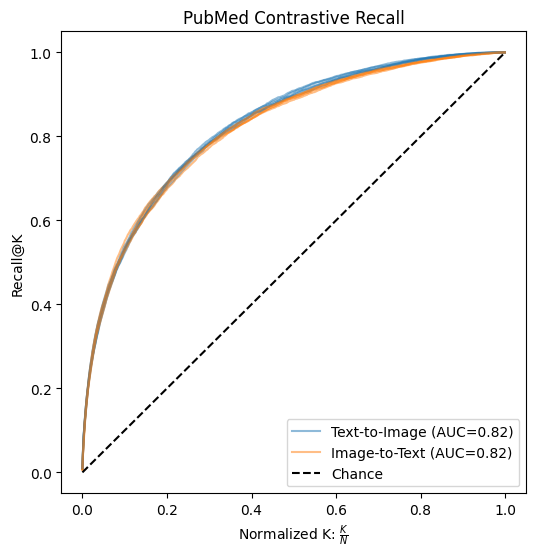

In [206]:
fig, ax = plt.subplots(figsize=(6, 6))

x = np.arange(0, len(latent_img), 10) / len(latent_img)

auc_t_to_i = 0
auc_i_to_t = 0
n = len(txt_to_img)
for idx, (t_to_i, i_to_t) in enumerate(zip(txt_to_img, img_to_txt)):

    auc_t_to_i += auc(x, t_to_i)
    auc_i_to_t += auc(x, i_to_t)

    label=f"Text-to-Image (AUC={round(auc_t_to_i / n, 2)})" if idx == n-1  else None
    ax.plot(x, t_to_i, label=label, color="C0", alpha=0.5)

    label=f"Image-to-Text (AUC={round(auc_i_to_t / n, 2)})" if idx == n-1 else None
    ax.plot(x, i_to_t, label=label, color="C1", alpha=0.5)

ax.plot([0, 1], [0, 1], color='k', ls='--', label="Chance")
ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")
ax.set_ylabel("Recall@K")
ax.set_title("PubMed Contrastive Recall")
plt.legend()
plt.savefig("/mnt/c/Users/ryanp/Desktop/pubmed_recall_contr.svg", dpi=300)

In [ ]:
true_to_gen_b2t = []
gen_to_true_b2t = []

for idx, (train, test) in enumerate(kf.split(np.arange(len(pmids)))):

    # Load pre-trained (from above)
    autoencoder = torch.load(data_dir / f"autoencoder_kfold-{str(idx)}.pt", weights_only=False).eval()
    proj_head_text = torch.load(data_dir / f"proj_head_text_infonce_kfold-{str(idx)}.pt", weights_only=False).eval()
    proj_head_image = torch.load(data_dir / f"proj_head_image_infonce_kfold-{str(idx)}.pt", weights_only=False).eval()
    proj_head = torch.load(data_dir / f"proj_head_text_mse_kfold-{str(idx)}.pt", weights_only=False).eval()

    with torch.no_grad():
        X_pred = torch.sigmoid(autoencoder(neuro_vectors[test]))

    # contrastive
    with torch.no_grad():
        latent_img = autoencoder.encoder(neuro_vectors[test])
        latent_img_proj = F.normalize(proj_head_image(latent_img), dim=1)
        latent_text = F.normalize(proj_head_text(F.normalize(latent_text_specter[test].to(device), dim=1)), dim=1)

    # brain-to-text
    with torch.no_grad():
        feature_emb = F.normalize(proj_head_text(F.normalize(specter(features.tolist()), dim=1)), dim=1)
        sim = latent_img_proj @ feature_emb.to(device).T
        inds = torch.argsort(sim, descending=True, dim=1)
        f = [", ".join(features[i.cpu().numpy()].tolist()) for i in inds[:, :10]]

    with torch.no_grad():
        latent_text_gen = specter(f).to(device)
        latent_text_gen_proj = F.normalize(proj_head_text(F.normalize(latent_text_gen, dim=1)), dim=1)
    t_to_g_b2t, g_to_t_b2t = recall_curve(latent_text.cpu(), latent_text_gen_proj.cpu(), step=10)

    true_to_gen_b2t.append(t_to_g_b2t)
    gen_to_true_b2t.append(g_to_t_b2t)
    if idx == 1:
        break

true_to_gen_b2t = torch.stack(true_to_gen_b2t)
gen_to_true_b2t = torch.stack(gen_to_true_b2t)

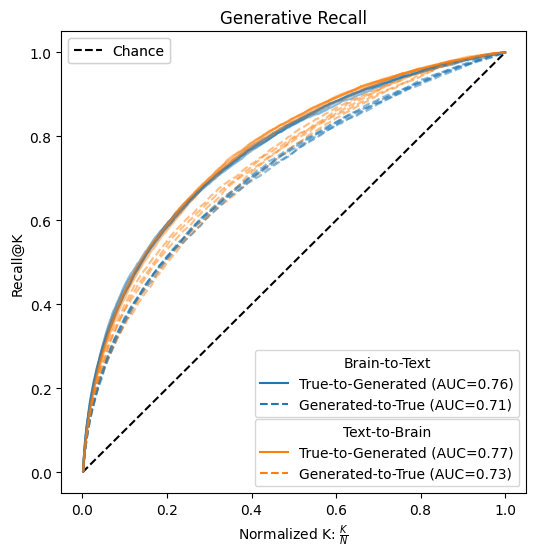

In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6, 6))

auc_btt_tg = 0
auc_btt_gt = 0
auc_ttb_tg = 0
auc_ttb_gt = 0
n = len(true_to_gen_t2b)

ax.plot([0, 1], [0, 1], color="k", ls="--", label="Chance")

for idx, (t_to_g_t2b, g_to_t_t2b, t_to_g_b2t, g_to_t_b2t) in enumerate(
    zip(true_to_gen_t2b, gen_to_true_t2b, true_to_gen_b2t, gen_to_true_b2t)
):

    # --- Text-to-Brain (orange / C1) ---
    x0 = np.arange(1, len(t_to_g_t2b) + 1) / len(t_to_g_t2b)

    auc_btt_tg += auc(x0, t_to_g_t2b)
    auc_btt_gt += auc(x0, g_to_t_t2b)

    ax.plot(x0, t_to_g_t2b, color="C0", ls="-",  label="_nolegend_", alpha=0.5)
    ax.plot(x0, g_to_t_t2b, color="C0", ls="--", label="_nolegend_", alpha=0.5)

    # --- Brain-to-Text (blue / C0) ---
    x1 = np.arange(1, len(t_to_g_b2t) + 1) / len(t_to_g_b2t)

    auc_ttb_tg += auc(x1, t_to_g_b2t)
    auc_ttb_gt += auc(x1, g_to_t_b2t)

    ax.plot(x1, t_to_g_b2t, color="C1", ls="-",  label="_nolegend_", alpha=0.5)
    ax.plot(x1, g_to_t_b2t, color="C1", ls="--", label="_nolegend_", alpha=0.5)


    if idx == n-1:
        # --- Two grouped legends ---
        btt_handles = [
            Line2D([0], [0], color="C0", ls="-"),
            Line2D([0], [0], color="C0", ls="--"),
        ]
        btt_labels = [
            f"True-to-Generated (AUC={(auc_btt_tg/n):.2f})",
            f"Generated-to-True (AUC={(auc_btt_gt/n):.2f})",
        ]

        ttb_handles = [
            Line2D([0], [0], color="C1", ls="-"),
            Line2D([0], [0], color="C1", ls="--"),
        ]
        ttb_labels = [
            f"True-to-Generated (AUC={(auc_ttb_tg/n):.2f})",
            f"Generated-to-True (AUC={(auc_ttb_gt/n):.2f})",
        ]


        leg1 = ax.legend(ttb_handles, ttb_labels, title="Text-to-Brain",
                        loc="lower right", bbox_to_anchor=(1.0, 0.),frameon=True)
        ax.add_artist(leg1)  # keep the first legend

        leg2 = ax.legend(btt_handles, btt_labels, title="Brain-to-Text",
                        loc="lower right", bbox_to_anchor=(1.0, 0.15), frameon=True)
        ax.add_artist(leg2)

        leg3 = ax.legend()
        ax.add_artist(leg3)


    ax.set_ylabel("Recall@K")
    ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")

    ax.set_title("Generative Recall")
    plt.savefig("/mnt/c/Users/ryanp/Desktop/pubmed_recall_gen.svg", dpi=300)
